 # Outline:

<ol start="1">
<li> Decision Trees</li>
<li> Understand the concepts of bagging and random forests </li>
<li> Boosting</li>
</ol>

In [1]:
# imports
%matplotlib inline
import numpy as np
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostRegressor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

## Understanding Decision Trees

In this course, it's important to understand the models that you can use to help you with your data, and this includes not only knowing how to invoke these as tools within Python libraries (e.g., ``sklearn``, ``statsmodels``), but to have an understanding of what each model is actually doing 'under the hood' -- how it actually works -- as this provides insights into why you should use one model vs another, and how you could adjust models and invent new ones!


### Entropy (Uncertainty)

In data science and machine learning, our models are often just finding patterns in the data. For example, for classification, it is best when our data is separable by their $Y$ class lables (e.g., cancerous or benign). That is, hopefully the $X$ values for one class label (e.g., cancerous) is disjoint and separated from the $X$ values that correspond to another class label (e.g., benign). If so, our model would be able to easily discern if a given, new piece of data corresponds to the cancerous label or benign label, based on its $X$ values. If the data is not easily separable (i.e., the $X$ values corresponding to cancer looks very similar to $X$ values corresponding to benign), then our task is difficult and perhaps impossible. Along these lines, we can measure this element in terms of how messy/confusable/_uncertain_ a collection of data is.

In the 1870s, physicists introduced a term ``Gibbs Entropy``, which was useful in statistical thermodynamics, as it effectively measured uncertainty. By the late 1920s, the foundational work in Information Theory had begun; pioneers John von Neumann and Claude Shannon conducted phenomenal work which paved the way for computation at large -- they heavily influenced the creation of computer science, and their work is still seen in modern day computers. Information theory concerns [entropy.](https://en.wikipedia.org/wiki/Entropy_(information_theory)) So let's look at an example to concretely address what entropy is (the information theoretic version of it).

Say that we have a fair coin $X$, and each coin flip is an observation. The coin is equally likely to yield heads or tails. The uncertainty is very high. In fact, it's the highest possible, as it's truly a 50/50 chance of either. Let $H(X)$ represent the entropy of $X$. Per the graphic below, we see that entropy is in fact highest when the probabilities of a 2-class variable are a 50/50 chance.

<div>
<img src="coin_flip.png" width="300"/>
</div>

If we had a cheating coin, whereby it was guaranteed to always be a head (or a tail), then our entropy would be 0, as there is no **uncertainty** about its outcome. Again, this term, entropy, predates decision trees and has vast applications. Alright, so we can see what entropy is measuring (the uncertainty), but how was it actually calculated?

#### Definition:
Entropy factors in _all_ possible values/classes of a random variable (log base 2):
<div>
<img src="entropy_definition.svg" width="250"/>
</div>

#### Fair-Coin Example
In our fair coin example, we only have 2 classes, both of which have a probability of 1/2. So, to calculate the overall entropy of the fair coin, we have Entropy(1+, 1-) =
<p>
<center>
$H(X)$ = -1 * (P(coin=heads)*log(P(coin=heads)) + P(coin=tails)*log(P(coin=tails)))
</center>

<p>
<center>
$ = -1 * (\frac{1}{2}log(\frac{1}{2}) + \frac{1}{2}log(\frac{1}{2}))$
</center>
    
<p>
<center>
$ = -1 * (\frac{1}{2}*-1) + \frac{1}{2}*-1)$
</center>
    
<p>
<center>
$ = -1 * (-\frac{1}{2} + -\frac{1}{2})$
</center>
    
<p>
<center>
$ = -1*-1 = 1$
</center>


### Worked Example

Let's say that we have a small, 14-observation dataset that concerns if we will play tennis on a given day or not (Play Tennis will be our output $Y$), based on 4 features of the current weather:
<p>
<div>
<img src="play_tennis_dataset.png" width="500"/>
</div>
<p>
Completely independent of the features, we can calculate the overall entropy of playing tennis, Entropy for (9+, 5-) examples =

<p>
<center>
$H(X) = -1 * (P$(play_tennis=yes)*log(P(play_tennis=yes)) + P(play_tennis=no)*log(P(play_tennis=no)))
</center>

<p>
<center>
$ = -\frac{9}{14}log(\frac{9}{14}) - \frac{5}{14}log(\frac{5}{14}) = 0.94$
</center>
    
Okay, **0.94** is pretty horrible, as it's close to 1, which is the worst possible value. This means that a priori, if we use no features, it's hard to predict if we will play tennis or not. There's a lot of uncertainty (aka entropy). To improve this, could we segment our data in such a way that it's more clear if we will play tennis or not (i.e., by more clear, I mean we will have lower uncertainty... lower entropy).

Let's start with looking at the ``Wind`` feature. There are 2 possible values for the Wind attribute, **weak** or **strong.** If we were to look at the subset of data that has weak wind, we see that there are 8 data samples (6 are 'Yes' for Play Tennis, 2 have 'No' for Play Tennis). Hmm, so if we know that the Wind is weak, it helps inform us that there's a 6/8 (75%) chance that we will Play Tennis. Let's put this in terms of entropy:

When we look at ONLY the Wind is Weak subset of data, we have a Play Tennis entropy for (6+, 2-) examples, which calculates to:
<p>
<center>
$H(X) = -1 * (P($play_tennis=yes$)*log(P$(play_tennis=yes$)) + P($play_tennis$=$no$)*log(P($play_tennis$=no)))$
</center>

<p>
<center>
$ = -\frac{6}{8}log(\frac{6}{8}) - \frac{2}{8}log(\frac{2}{8}) = 0.811$
</center>

A value of 0.811 may seem sadly high, still, but our calculation was correct. If you reference the figure above that shows the entropy of a fair coin, we see that having a probability of 75% does in fact yield an entropy of 0.811.

We're only looking at a subset of our data though (the subset for Wind is Weak). We now need to look at the rest of our data (the subset for Wind is Strong). When the Wind is Strong, we have 6 data points: 3 have Play Tennis is Yes, and 3 are No). In short-hand notation, we have (3+, 3-), which is a 0.5 probability, and we know already that this yields an Entropy of 1.

When looking at this possible division of separating our data according to the value of Wind, the hope was that we'd have very low entropy in each subset of data. Imagine if the Wind attribute perfectly aligned with Playing Tennis or not (the values were identical). In that case, we would have an Entropy of 0 (no uncertainty), and thus, it would be INCREDIBLY useful to predict playing tennis or not based on the Wind attribute (it would tell us the exact answer).

We saw that the Wind attribute didn't yield an entropy of 0; its two classes (weak and strong) had an entropy of 0.811 and 1, respectively. Is Wind a useful feature for us then? In order quantitatively measure its usefulness, we can use the entropy to calculate ``Information Gain``:

<p>
<center>
$Gain(S) = H(S) - \sum_{i}\frac{|S_{i}|}{|S|}*H(S_{i})$
</center>

Let $S$ represent our current data, and each $S_{i}$ is a subset of the data split according to each of the possible values. So, when considering splitting on Wind, our Information Gain is:

<p>
<center>
$Gain($alldata)$ = H($alldata$) - \frac{|S_{windweak}|}{|S|}H(S_{windweak}) - \frac{|S_{windstrong}|}{|S|}H(S_{windstrong})$
</center>

<p>
<center>
$ = 0.94 - \frac{8}{14}0.811 - \frac{6}{14}1.00 = 0.048$
</center>

Okay, using Wind as a feature to split our data yields an Information Gain of 0.048. That looks like a low value. We want a high value because gain is good (we want to separate our data in a way that the increases our information). Is 0.048 bad? It all depends on the dataset.

<p>

### Summary:

To build a decision tree:
<ul>
  <li>Start with an empty tree and some data $X$</li>
  <li>Decide what your splitting criterion will be (e.g., Gini, Entropy, etc)</li>
  <li>Decide what your what your stopping criterion will be, or if you'll develop a large tree and prune</li>
  <li>Build the tree in a greedy manner, and if you have multiple hyperparameters, use cross-validation to determine the best values</li>
</ul>  


## Sklearn's Implementation

Our beloved `sklearn` library has implementations of DecisionTrees, so let's practice using it.

First, let's load our Play Tennis data:

In [2]:
tennis_df = pd.read_csv("play_tennis.csv")
tennis_df = pd.get_dummies(tennis_df, columns=['outlook', 'temp', 'humidity', 'windy'])
tennis_df

play  outlook_overcast  outlook_rainy  outlook_sunny  temp_cool  temp_hot  temp_mild  humidity_high  humidity_normal  windy_False  windy_True
0    no                 0              0              1          0         1          0              1                0            1           0
1    no                 0              0              1          0         1          0              1                0            0           1
2   yes                 1              0              0          0         1          0              1                0            1           0
3   yes                 0              1              0          0         0          1              1                0            1           0
4   yes                 0              1              0          1         0          0              0                1            1           0
5    no                 0              1              0          1         0          0              0                1            0           1
6   yes                 1              0              0          1         0          0              0                1            0           1
7    no                 0              0              1          0         0          1              1                0            1           0
8   yes                 0              0              1          1         0          0              0                1            1           0
9   yes                 0              1              0          0         0          1              0                1            1           0
10  yes                 0              0              1          0         0          1              0                1            0           1
11  yes                 1              0              0          0         0          1              1                0            0           1
12  yes                 1              0              0          0         1          0              0                1            1           0
13   no                 0              1              0          0         0          1              1                0            0           1

In [3]:
# separate our data into X and Y portions
x_train = tennis_df.iloc[:, tennis_df.columns != 'play'].values
y_train = tennis_df['play'].values
x_train.shape

(14, 10)

We can build a DecisionTree classifier as follows:

In [4]:
dt = DecisionTreeClassifier().fit(x_train, y_train)

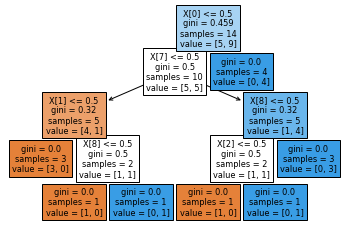

In [5]:
tree_vis = tree.plot_tree(dt, filled=True)

In the above example, we did not use the tree to do any classification. Our data was too small to consider such.

Let's turn to a different dataset:

## 2016 Election Data
We will be attempting to predict the presidential election results (at the county level) from 2016, measured as 'votergap' = (trump - clinton) in percentage points, based mostly on demographic features of those counties.  Let's quick take a peak at the data:

In [6]:
elect_df = pd.read_csv("county_level_election.csv")
elect_df.head()

state  fipscode             county  population  hispanic  minority  female  unemployed  income  nodegree  bachelor  inactivity  obesity  density  cancer  votergap   trump  clinton
0  Colorado      8117      Summit County       27239    15.173     4.918  45.996         2.5   68352       5.4      48.1         8.1     13.1     46.0    46.2   -27.632  31.530   59.162
1  Colorado      8037       Eagle County       53653    30.040     5.169  47.231         3.1   76661      10.1      47.3         9.4     11.8     31.0    47.1   -19.897  36.058   55.955
2     Idaho     16067    Minidoka County       19226    34.070     5.611  49.318         3.7   46332      24.1      11.8        18.3     34.2     80.0    61.8    54.148  71.135   16.987
3  Colorado      8113  San Miguel County        7558    10.154     4.747  46.808         3.7   59603       4.7      54.4        12.4     16.7      5.7    62.6   -44.769  23.892   68.662
4      Utah     49051     Wasatch County       21600    13.244     4.125  48.812         3.4   65207       9.5      34.4        13.9     23.0    257.8    68.3    25.357  50.471   25.114

In [7]:
# split 80/20 train-test
X = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,response,test_size=0.2)

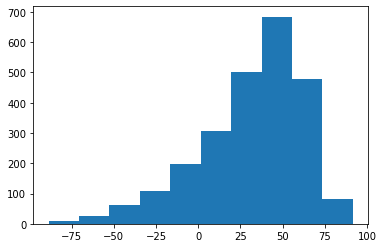

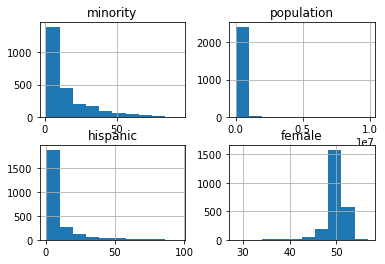

In [8]:
plt.hist(ytrain)
Xtrain.hist(column=['minority', 'population','hispanic','female']);

In [9]:
print(elect_df.shape)
print(Xtrain.shape)
print(Xtest.shape)

(3066, 18)
(2452, 12)
(614, 12)


## Regression Trees

We will start by using a simple Decision Tree Regressor to predict votergap. We'll run a few of these models without any cross-validation or 'regularization', just to illustrate what is going on.

This is what you ought to keep in mind about decision trees.

from the docs:
```
max_depth : int or None, optional (default=None)
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
min_samples_split : int, float, optional (default=2)
```

- The deeper the tree, the more prone you are to overfitting.
- The smaller `min_samples_split`, the more the overfitting. One may use `min_samples_leaf` instead. More samples per leaf, the higher the bias.

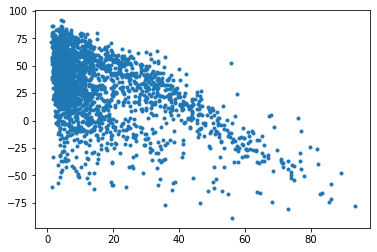

In [10]:
from sklearn.tree import DecisionTreeRegressor
x = Xtrain['minority'].values
o = np.argsort(x)
x = x[o]
y = ytrain.values[o]
plt.plot(x,y, '.');

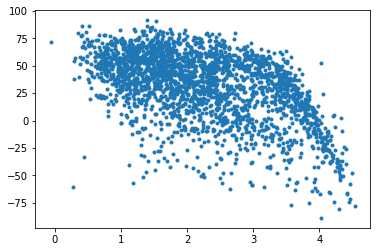

In [11]:
plt.plot(np.log(x),y, '.'); # log scale

<p>
<div class="exercise"><b>Q10:</b> Which of the two versions of 'minority' would be a better choice to use as a predictor for prediction?</div>


They would be equally useful. The log-scale is easier to visualize, so we will use it.

(2452,)
(2452, 1)


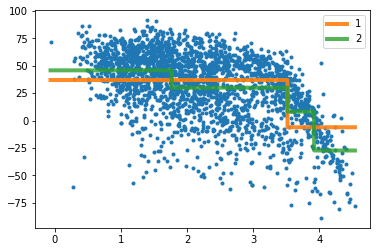

In [12]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
print(np.log(x).shape)
print(xx.shape)
for i in [1,2]:
    dtree = DecisionTreeRegressor(max_depth=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=1-i/10, lw=4)
plt.legend();

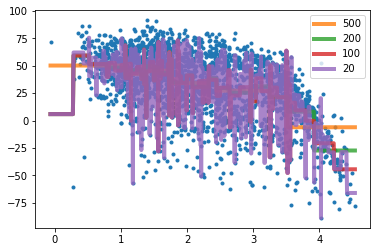

In [13]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]:
    dtree = DecisionTreeRegressor(min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

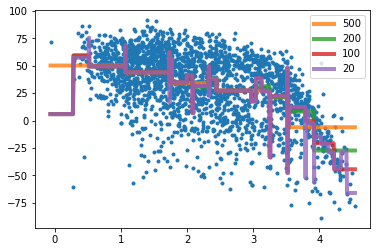

In [14]:
plt.plot(np.log(x),y,'.')
xx = np.log(x).reshape(-1,1)
for i in [500,200,100,20]:
    dtree = DecisionTreeRegressor(max_depth=6, min_samples_split=i)
    dtree.fit(xx, y)
    plt.plot(np.log(x), dtree.predict(xx), label=str(i), alpha=0.8, lw=4)
plt.legend();

In [15]:
#let's also include logminority as a predictor going forward
xtemp = np.log(Xtrain['minority'].values)
Xtrain = Xtrain.assign(logminority = xtemp)
Xtest = Xtest.assign(logminority = np.log(Xtest['minority'].values))
Xtrain.head()


population  hispanic  minority  female  unemployed  income  nodegree  bachelor  inactivity  obesity  density  cancer  logminority
1034     5287037    25.185    34.329  51.500         6.1   55058      15.2      35.3        20.1     25.3    106.0   207.7     3.535990
1389       46414     7.782    28.274  51.930         6.6   40357      18.6      17.8        26.9     33.0     72.0   223.4     3.341943
468       413204    19.818    19.778  51.660         4.8   56443       7.8      35.0        20.4     24.6   1367.0   169.8     2.984570
2397       71797    10.132    12.473  48.667         8.9   43205      13.5      15.0        25.5     36.9     38.3   268.6     2.523566
2376       26213     0.778     2.184  50.602         9.1   36375      16.2      13.6        34.5     38.2     40.6   267.9     0.781158

Ok with this discussion in mind, lets improve this model by Bagging.

## Bootstrap-Aggregating (called Bagging)



The basic idea:
- A Single Decision tree is likely to overfit.
- So lets introduce replication through Bootstrap sampling.
- **Bagging** uses bootstrap resampling to create different training datasets. This way each training will give us a different tree.
- Added bonus: the left off points can be used to as a natural "validation" set, so no need to 
- Since we have many trees that we will **average over for prediction**, we can choose a large `max_depth` and we are ok as we will rely on the law of large numbers to shrink this large variance, low bias approach for each individual tree.

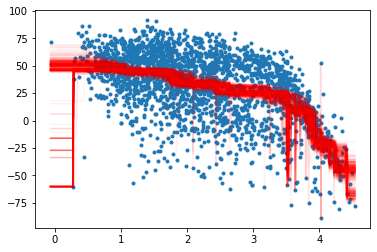

In [16]:
from sklearn.utils import resample
# how about BaggingRegressor?
ntrees = 500
estimators = []
R2s = []
yhats_test = np.zeros((Xtest.shape[0], ntrees))

plt.plot(np.log(x),y,'.')
for i in range(ntrees):
    simpletree = DecisionTreeRegressor(max_depth=3)
    boot_xx, boot_y = resample(Xtrain[['logminority']], ytrain)
    estimators = np.append(estimators,simpletree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,simpletree.score(Xtest[['logminority']], ytest))
    yhats_test[:,i] = simpletree.predict(Xtest[['logminority']])
    plt.plot(np.log(x), simpletree.predict(np.log(x).reshape(-1,1)), 'red', alpha=0.05)

In [17]:
yhats_test.shape

(614, 500)

<div class="exercise">**Exercise 2**</div>
1. Edit the code below (which is just copied from above) to refit many bagged trees on the entire xtrain feature set (without the plot...lots of predictors now so difficult to plot). 
2. Summarize how each of the separate trees performed (both numerically and visually) using $R^2$ as the metric.  How do they perform on average?
3. Combine the trees into one prediction and evaluate it using $R^2$.
4. Briefly discuss the results.  How will the results above change if 'max_depth=4' is increased?  What if it is decreased?

In [18]:
from sklearn.metrics import r2_score


ntrees = 500
estimators = []
R2s = []
yhats_test = np.zeros((Xtest.shape[0], ntrees))

for i in range(ntrees):
    dtree = DecisionTreeRegressor(max_depth=3)
    boot_xx, boot_y = resample(Xtrain[['logminority']], ytrain)
    estimators = np.append(estimators,dtree.fit(boot_xx, boot_y))
    R2s = np.append(R2s,dtree.score(Xtest[['logminority']], ytest))
    yhats_test[:,i] = dtree.predict(Xtest[['logminority']])

# your code here


#### Your answer here

<hr style='height:2px'>

## Random Forests

What's the basic idea?

Bagging alone is not enough randomization, because even after bootstrapping, we are mainly training on the same data points using the same variablesn, and will retain much of the overfitting.

So we will build each tree by splitting on "random" subset of predictors at each split (hence, each is a 'random tree').  This can't be done in with just one predcitor, but with more predictors we can choose what predictors to split on randomly and how many to do this on.  Then we combine many 'random trees' together by averaging their predictions, and this gets us a forest of random trees: a **random forest**.

Below we create a hyper-param Grid. We are preparing to use the bootstrap points not used in training for validation.
(OOB)
```
max_features : int, float, string or None, optional (default=”auto”)
- The number of features to consider when looking for the best split.
```

- `max_features`: Default splits on all the features and is probably prone to overfitting. You'll want to validate on this. 
- You can "validate" on the trees `n_estimators` as well but many a times you will just look for the plateau in the trees as seen below.
- From decision trees you get the `max_depth`, `min_samples_split`, and `min_samples_leaf` as well but you might as well leave those at defaults to get a maximally expanded tree.

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [20]:
# code from 
# Adventures in scikit-learn's Random Forest by Gregory Saunders
from itertools import product
from collections import OrderedDict
param_dict = OrderedDict(
    n_estimators = [400, 600, 800],
    max_features = [0.2, 0.4, 0.6, 0.8]
)

param_dict.values()

odict_values([[400, 600, 800], [0.2, 0.4, 0.6, 0.8]])

### Using the OOB error

We have been putting "validate" in quotes. This is because the bootstrap gives us left-over points! So we'll now engage in our very own version of a grid-search, done over the out-of-bag scores that `sklearn` gives us for free

In [21]:
#make sure ytrain is the correct data type...in case you have warnings
#print(yytrain.shape,ytrain.shape,Xtrain.shape)
#ytrain = np.ravel(ytrain)

#Let's Cross-val. on the two 'hyperparameters' we based our grid on earlier
results = {}
estimators= {}
for ntrees, maxf in product(*param_dict.values()):
    params = (ntrees, maxf)
    est = RandomForestRegressor(oob_score=True, 
                                n_estimators=ntrees, max_features=maxf, max_depth=50, n_jobs=-1)
    est.fit(Xtrain, ytrain)
    results[params] = est.oob_score_
    estimators[params] = est
outparams = max(results, key = results.get)
outparams

(800, 0.8)

In [22]:
rf1 = estimators[outparams]

In [23]:
rf1.score(Xtest, ytest)

0.78036259282083

Finally you can find the **feature importance** of each predictor in this random forest model. Whenever a feature is used in a tree in the forest, the algorithm will log the decrease in the splitting criterion (such as gini). This is accumulated over all trees and reported in `est.feature_importances_`

<AxesSubplot:>

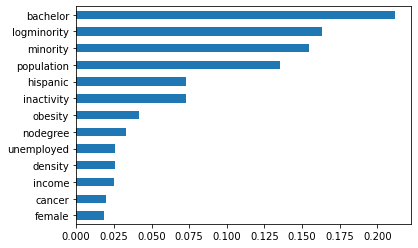

In [24]:
pd.Series(rf1.feature_importances_,index=list(Xtrain)).sort_values().plot(kind="barh")

Since our response isn't very symmetric, we may want to suppress outliers by using the `mean_absolute_error` instead. 

In [25]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ytest, rf1.predict(Xtest))

12.084092280130294

<hr style='height:2px'>

## Boosting

None of the models we've previously discussed have the ability to learn from their final predictions, which is what boosting allows us to do. Sure, we train a model iteratively over data (possibly multiple epochs), but its final predictions/errors are never used to train new models. 

Boosting allows us to do this, and it tends to use a bunch of 'weak' models. The reason for using weak models is that if we used very expressive models, our combined models would likely overfit pretty quickly. In short, we should learn from our models' mistakes. Gradient Boosting is typically used for regression tasks, as it models the residuals. AdaBoost is typically used for classification tasks. AdaBoost explicitly weights the dataset for each model based on the previous mdoels' misclassifications. That is, our dataset is constantly being changed after each model, based on the misclassification from our accumulative model. Moreover, the model's accuracy is used for determining how much weight (aka, how much stock or faith) we should place on that given model.

High-level idea: course slides

More Details: [CMU's slides from their Machine Learning Algorithms course.](https://www.cs.cmu.edu/~atalwalk/teaching/winter17/cs260/lectures/lec13.pdf)

## Sklearn's Implementation

Our beloved `sklearn` library has an implementation of AdaBoost, so let's practice using it.

In [26]:
elect_df = pd.read_csv("county_level_election.csv")
elect_df.head()

state  fipscode             county  population  hispanic  minority  female  unemployed  income  nodegree  bachelor  inactivity  obesity  density  cancer  votergap   trump  clinton
0  Colorado      8117      Summit County       27239    15.173     4.918  45.996         2.5   68352       5.4      48.1         8.1     13.1     46.0    46.2   -27.632  31.530   59.162
1  Colorado      8037       Eagle County       53653    30.040     5.169  47.231         3.1   76661      10.1      47.3         9.4     11.8     31.0    47.1   -19.897  36.058   55.955
2     Idaho     16067    Minidoka County       19226    34.070     5.611  49.318         3.7   46332      24.1      11.8        18.3     34.2     80.0    61.8    54.148  71.135   16.987
3  Colorado      8113  San Miguel County        7558    10.154     4.747  46.808         3.7   59603       4.7      54.4        12.4     16.7      5.7    62.6   -44.769  23.892   68.662
4      Utah     49051     Wasatch County       21600    13.244     4.125  48.812         3.4   65207       9.5      34.4        13.9     23.0    257.8    68.3    25.357  50.471   25.114

In [27]:
# NOTICE that a negative votergap means more people voted for clinton than trump; a positive votergap means more people voted for trump

# split 80/20 train-test
X = elect_df[['population','hispanic','minority','female','unemployed','income','nodegree','bachelor','inactivity','obesity','density','cancer']]
response = elect_df['votergap']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,response,test_size=0.2)

In [35]:
estab = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=1), n_estimators=200, learning_rate=1.0)
estab.fit(xx, y)
staged_predict_generator = estab.staged_predict(xx)

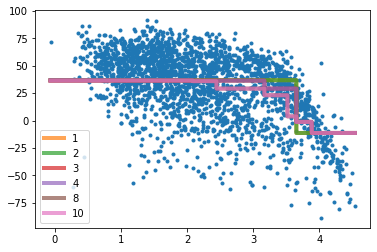

In [36]:
import time
from IPython import display
plt.plot(xx, y, '.');
counter = 0
for stagepred in staged_predict_generator:
    counter = counter + 1
    if counter in [1, 2, 3, 4, 8, 10]:
        plt.plot(xx, stagepred, alpha=0.7, label=str(counter), lw=4)
        plt.legend();
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)

Ok, so this demonstration helps us understand some things about boosting.

- `n_estimators` is the number of trees, and thus the stage in the fitting. It also controls the complexity for us. The more trees we have the more we fit to the tiny details.
- `staged_predict` gives us the prediction at each step
- once again `max_depth` from the underlying decision tree tells us the depth of the tree. But here it tells us the amount of features interactions we have, not just the scale of our fit. But clearly it increases the variance again.

Ideas from decision trees remain. For example, increase `min_samples_leaf` or decrease `max_depth` to reduce variance and increase the bias.